In [1]:
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Common import NeuralNet, fit
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [96]:
##### GLOBAL PARAMETERS #####

d = 2

x1_min, x1_max = -1.0, 1.0
x2_min, x2_max = -1.0, 1.0

mu_min, mu_max = -1.0, 1.0

final_time = 0.1

# Define the initial condition function
def u0(input_vector):
    u = 0
    for m in range(1, d+1):
        u -= input_vector[2+m-1] * np.sin(np.pi * m * input_vector[0]) * np.sin(np.pi * m * input_vector[1]) / np.sqrt(m)
    return u / d

# Define the solution function
def u(t, input_vector):
    u = 0
    for m in range(1, d+1):
        u -= np.exp(-(np.pi * m) ** 2 * t) * input_vector[2+m-1] * np.sin(np.pi * m * input_vector[0]) * np.sin(np.pi * m * input_vector[1]) / np.sqrt(m)
    return u / d

# Parametric approach

In [97]:
##### GENERATE TRAINING INPUT #####

num_positions = 16**2 # 32**2
num_params = 128 # 32**d

# positions

soboleng_positions = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
sobol_positions = soboleng_positions.draw(num_positions).numpy()

sobol_positions[:, 0] *= (x1_max-x1_min)
sobol_positions[:, 0] += x1_min 
sobol_positions[:, 1] *= (x2_max-x2_min) 
sobol_positions[:, 1] += x2_min

# parameters

soboleng_params = torch.quasirandom.SobolEngine(dimension=d, scramble=True)
sobol_params = soboleng_params.draw(num_params).numpy()
# sobol_params = torch.rand((num_params, d))

for m in range(d):
    sobol_params[:, m] = sobol_params[:, m] * (mu_max-mu_min) + mu_min 

training_inputs = np.zeros((num_positions*num_params, 2+d))
training_inputs[:, 0] = np.tile(sobol_positions[:, 0], num_params)
training_inputs[:, 1] = np.tile(sobol_positions[:, 1], num_params)
for m in range(d):
    training_inputs[:, 2+m] = np.tile(sobol_params[:, m], num_positions).reshape(num_positions, num_params).transpose().flatten()

print(training_inputs.shape)
np.save("data/training_inputs.npy", training_inputs)


##### GENERATE TRAINING OUTPUT #####

training_outputs = u(final_time, training_inputs.transpose())
print(training_outputs.shape)
np.save("data/training_outputs.npy", training_outputs)

(32768, 4)
(32768,)


(32768, 4) (32768,)


Text(0.5, 0.92, 'Solution at final time')

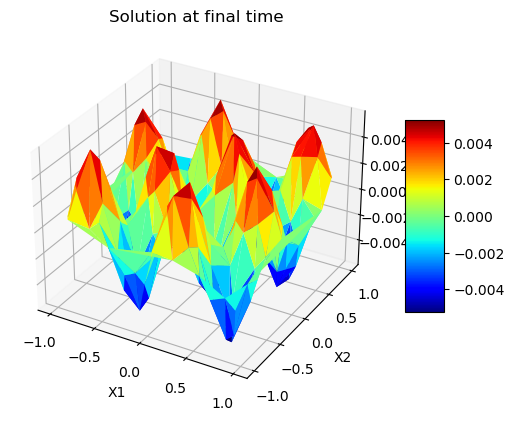

In [98]:
input_train = np.load("data/training_inputs.npy")
output_train = np.load("data/training_outputs.npy")

print(input_train.shape, output_train.shape)

in_test = input_train[:num_positions, :]
X_test, Y_test = in_test[:, 0], in_test[:, 1]
out_test = output_train[:num_positions]
_min, _max = np.min(out_test), np.max(out_test)

fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X_test, Y_test, out_test, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Solution at final time')

C:\Users\ambro\AppData\Local\Temp\ipykernel_8820\556794651.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_dataset = TensorDataset(torch.tensor(input_train_torch), torch.tensor(output_train_torch))
C:\Users\ambro\AppData\Local\Temp\ipykernel_8820\556794651.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(input_test_torch), torch.tensor(output_test_torch))


number of degrees of freedom: 7345 7345
################################  0  ################################
Training loss:  0.3552586779070015 Test loss:  0.024692143098666124
################################  1  ################################
Training loss:  0.012949863672614671 Test loss:  0.007777431048452854
################################  2  ################################
Training loss:  0.006355809029908135 Test loss:  0.00530631306509559
################################  3  ################################
Training loss:  0.004549920155953329 Test loss:  0.004075770929025916
################################  4  ################################
Training loss:  0.003536956505670857 Test loss:  0.0032055621178677454
################################  5  ################################
Training loss:  0.002859572481471472 Test loss:  0.0026534450097152823
################################  6  ################################
Training loss:  0.0023709968484651586 Test loss:  0

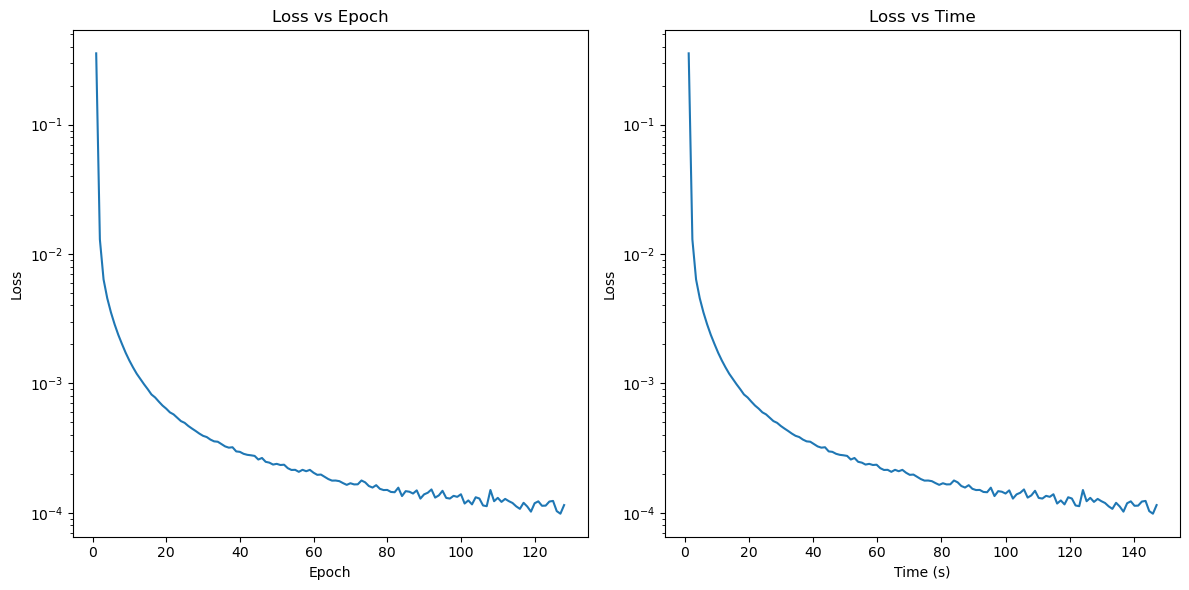

In [99]:
##### FINAL TRAINING DATA RETYPING #####

n_train = int(0.8*input_train.shape[0])

input_train_torch = torch.tensor(input_train[:n_train, :], dtype=torch.float32)
output_train_torch = torch.tensor(output_train[:n_train], dtype=torch.float32)
input_test_torch = torch.tensor(input_train[n_train:, :], dtype=torch.float32)
output_test_torch = torch.tensor(output_train[n_train:], dtype=torch.float32)

input_train_torch = input_train_torch.to(device)
output_train_torch = output_train_torch.to(device)
input_test_torch = input_test_torch.to(device)
output_test_torch = output_test_torch.to(device)

batch_size = 512

training_dataset = TensorDataset(torch.tensor(input_train_torch), torch.tensor(output_train_torch))
training_dataset_dl = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(torch.tensor(input_test_torch), torch.tensor(output_test_torch))
test_dataset_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

##### MODEL DEFINITION #####

neurons_per_layer = 48
num_hidden_layers = 4

model = NeuralNet(
    input_dimension=2+d,
    output_dimension=1,
    n_hidden_layers=num_hidden_layers,
    neurons=neurons_per_layer,
    regularization_exp=0,
    regularization_param=0,
    retrain_seed=1
    )
model = model.to(device)

##### TRAINING #####

num_weights = (num_hidden_layers-1)*(neurons_per_layer+1)*neurons_per_layer + (2+d+1)*neurons_per_layer + (neurons_per_layer+1)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("number of degrees of freedom:", num_weights, pytorch_total_params)

learning_rate = 5e-4
num_epochs = 128

optimizer_ADAM = optim.Adam(
    model.parameters(),
    lr=float(learning_rate)
    )

history, epoch_time = fit(
    model=model,
    training_set=training_dataset_dl,
    num_epochs=num_epochs,
    optimizer=optimizer_ADAM,
    p=2,
    test_set=test_dataset_dl,
    verbose=True
)

# Plot history vs epoch and history vs epoch * epoch_time using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot history vs epoch
axes[0].plot(np.arange(len(history)) + 1, history)
axes[0].set_yscale('log')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")

# Plot history vs epoch * epoch_time
axes[1].plot((np.arange(len(history)) + 1) * epoch_time, history)
axes[1].set_xlabel("Time (s)")
axes[1].set_yscale('log')
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss vs Time")

plt.tight_layout()
plt.show()

In [25]:
print("d=2, n_params=7345, lr=1e-3, disc=32")
print(history)
print(epoch_time)

d=2, n_params=7345, lr=1e-3, disc=32
[0.038398604481699294, 0.0008414059753931724, 0.0004479656234934737, 0.0003057472573004816, 0.0002362405616054275, 0.00019308358722014418, 0.00016353138622093866, 0.00014052984039381045, 0.000123141964536444, 0.00011559024906659943, 0.00010501525198947093, 9.8710932363133e-05, 8.889720540139479e-05, 8.9278366885992e-05, 8.510656742544143e-05, 7.500605181576248e-05, 7.317703069276149e-05, 7.182694918839161e-05, 6.814597902859987e-05, 6.29733811123856e-05, 6.0831823482487835e-05, 5.9923161110475576e-05, 6.030238710508229e-05, 5.439491510372818e-05, 5.264372428470665e-05, 5.4215871564622375e-05, 5.0679181978097176e-05, 5.1458616908917065e-05, 4.793797441138281e-05, 4.4363033190109036e-05, 4.541344796749058e-05, 4.516093225603868e-05, 4.4408634650494605e-05, 4.0609512499401035e-05, 4.217767195768829e-05, 3.85121406409894e-05, 3.7094741582421875e-05, 4.003293000209851e-05, 3.6346967537070896e-05, 3.6506160450144876e-05, 3.413653472961187e-05, 3.411574343

test parameters: tensor([[0.1387, 0.8364]])
Max-point relative error =  0.17251847122968633
Mean max-point relative error: 0.17251847122968633


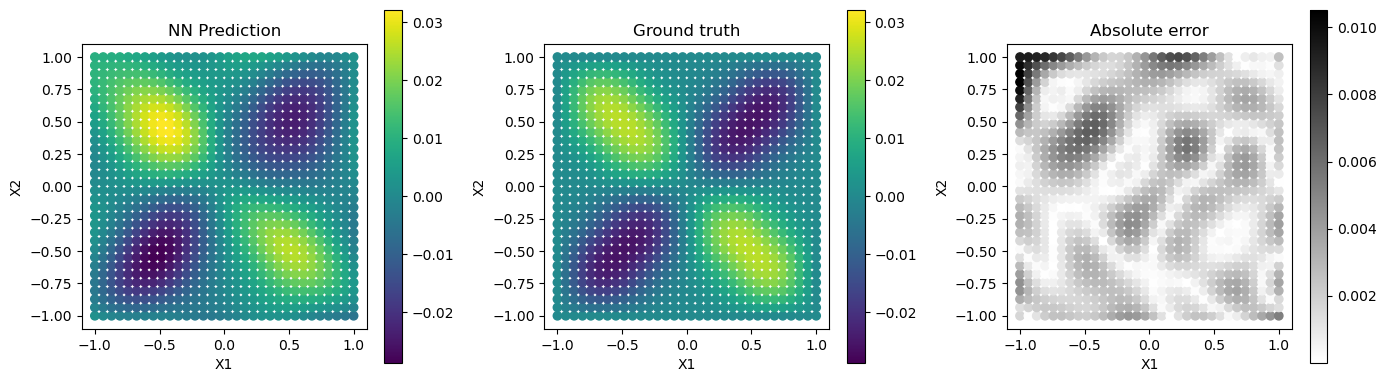

In [249]:
##### GENERATE TESTING DATA #####

average_error = 0
num_tests = 1
verbose = True

for _ in range(num_tests): 

    num_positions_test = discretization**2
    num_params_test = 1
    model = model.cpu()

    # positions

    x1_points = torch.linspace(x1_min, x1_max, discretization)
    x2_points = torch.linspace(x2_min, x2_max, discretization)
    position_grid = torch.stack(torch.meshgrid(x1_points, x2_points),axis=2).reshape((discretization, discretization, 2)).transpose(0,1).numpy()
    positions_test = np.reshape(position_grid, (num_positions_test, 2))

    # parameters

    mu_test = torch.rand((1,d))
    for m in range(d):
        mu_test[:, m] *= (mu_max-mu_min) 
        mu_test[:, m] += mu_min 
    mu_test = torch.tensor([[0.1387, 0.8364]])
    if verbose: print("test parameters:", mu_test)

    test_inputs = np.zeros((num_positions_test*num_params_test, 2+d))
    test_inputs[:, 0] = np.tile(positions_test[:, 0], num_params_test)
    test_inputs[:, 1] = np.tile(positions_test[:, 1], num_params_test)
    for m in range(d):
        test_inputs[:, 2+m] = np.tile(mu_test[:, m], num_positions_test).reshape(num_positions_test, num_params_test).transpose().flatten()

    prediction = np.array([model.forward(torch.tensor(test_inputs[i, :], dtype=torch.float32)).detach().item() for i in range(num_positions_test)])
    ground_truth = u(final_time, test_inputs.transpose())

    vmin = min(np.min(prediction), np.min(ground_truth))
    vmax = max(np.max(prediction), np.max(ground_truth))

    err = np.abs(ground_truth-prediction)
    if verbose: print("Max-point relative error = ", np.max(err)/(vmax-vmin))
    average_error += np.max(err)/(vmax-vmin)/num_tests

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
im1 = ax1.scatter(test_inputs[:, 0], test_inputs[:, 1], c=prediction, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im1)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('NN Prediction')
ax1.set_aspect(1)

ax2 = fig.add_subplot(132)
im2 = ax2.scatter(test_inputs[:, 0], test_inputs[:, 1], c=ground_truth, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im2)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('Ground truth')
ax2.set_aspect(1)

ax3 = fig.add_subplot(133)
im3 = ax3.scatter(test_inputs[:, 0], test_inputs[:, 1], c=err, cmap='binary')
plt.colorbar(im3)
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_title('Absolute error')
ax3.set_aspect(1)
fig.tight_layout()

print("Mean max-point relative error:", average_error)

# Operator approach

In [69]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')

##### 2D FOURIER LAYER #####

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.retrain_fno = fno_architecture["retrain_fno"]

        torch.manual_seed(self.retrain_fno)
        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        
        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.to(device)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1_padding = int(round(x.shape[-1] * self.padding_frac))
        x2_padding = int(round(x.shape[-2] * self.padding_frac))
        x = F.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [82]:
discretization = 16

x1_points = torch.linspace(x1_min, x1_max, discretization)
x2_points = torch.linspace(x2_min, x2_max, discretization)

position_grid = torch.stack(torch.meshgrid(x1_points, x2_points),axis=2).reshape((discretization, discretization, 2)).transpose(0, 1)

d = 3
n_samples = 128 # 32**d

param_samples = torch.rand((n_samples, d))*(mu_max - mu_min) + mu_min

fno_input_positions = torch.tile(position_grid.reshape((1, discretization**2, 2)), (n_samples, 1, 1))
# print(fno_input_positions.shape)
fno_input_params = torch.tile(param_samples.reshape(n_samples, 1, d), (1, discretization**2, 1))
# print(fno_input_params.shape)
fno_input_vectors = torch.concatenate((fno_input_positions, fno_input_params), axis=-1).reshape(n_samples*discretization*discretization, 2+d)
# print(fno_input_vectors.shape)

fno_input_train = torch.concatenate(
    (
        u0(np.transpose(fno_input_vectors)).reshape((n_samples, discretization, discretization, 1)), 
        fno_input_vectors[:, 0].reshape((n_samples, discretization, discretization, 1)),
        fno_input_vectors[:, 1].reshape((n_samples, discretization, discretization, 1))
    ), 
    axis=-1)
fno_output_train = u(final_time, np.transpose(fno_input_vectors)).reshape((n_samples, discretization, discretization, 1))

print("input:", fno_input_train.shape)
print("output:", fno_output_train.shape)

# np.savetxt("fno_input_vectors.csv", np.array(fno_input_vectors.detach()), delimiter=',')

n_train = int(0.8*n_samples)
print("n_train = ", n_train)

input_function_train = fno_input_train[:n_train, :, :, :]
output_function_train = fno_output_train[:n_train, :, :, :]
input_function_test = fno_input_train[n_train:, :, :, :]
output_function_test = fno_output_train[n_train:, :, :, :]

batch_size = 64

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

print(input_function_train.shape)
print(output_function_train.shape)
print(input_function_test.shape)
print(output_function_test.shape)

input: torch.Size([128, 16, 16, 3])
output: torch.Size([128, 16, 16, 1])
n_train =  102
torch.Size([102, 16, 16, 3])
torch.Size([102, 16, 16, 1])
torch.Size([26, 16, 16, 3])
torch.Size([26, 16, 16, 1])


number of degrees of freedom: 7009 7009
######### Epoch: 0  ######### Train Loss: 0.0018445670139044523  ######### Relative L2 Test Norm: 0.0009651236468926072
######### Epoch: 1  ######### Train Loss: 0.0012480519944801927  ######### Relative L2 Test Norm: 0.0017742926720529795
######### Epoch: 2  ######### Train Loss: 0.0016497005708515644  ######### Relative L2 Test Norm: 0.0008933998178690672
######### Epoch: 3  ######### Train Loss: 0.0009532390977256  ######### Relative L2 Test Norm: 0.0010954493191093206
######### Epoch: 4  ######### Train Loss: 0.001219521975144744  ######### Relative L2 Test Norm: 0.0010412990814074874
######### Epoch: 5  ######### Train Loss: 0.000991862965747714  ######### Relative L2 Test Norm: 0.0006988105596974492
######### Epoch: 6  ######### Train Loss: 0.0007931729487609118  ######### Relative L2 Test Norm: 0.0008540858398191631
######### Epoch: 7  ######### Train Loss: 0.0009067776845768094  ######### Relative L2 Test Norm: 0.0007155544590204954
#####

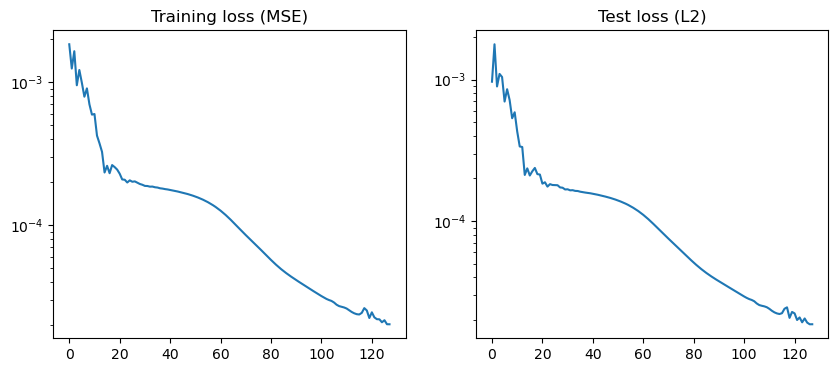

In [83]:
step_size = 10
gamma = 1

modes = 2
width = 16
n_layers = 2

fno_architecture = {
    "modes": modes,
    "width": width,
    "n_layers": n_layers,
    "retrain_fno": 1
}


fno = FNO2d(fno_architecture)

num_weights = (3+1)*width + n_layers*((width+1)*width + 2*width*width*modes*modes) + (width+1)*128 + (128+1)
pytorch_total_params = sum(p.numel() for p in fno.parameters() if p.requires_grad)
print("number of degrees of freedom:", num_weights, pytorch_total_params)


train_loss_mse = []
test_loss_l2 = []
learning_rate = 0.002

epochs = 128

optimizer = optim.Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

l = torch.nn.MSELoss()
freq_print = 1

start_time = time.time()

for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)
    train_loss_mse.append(train_mse)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) ) # / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)
        test_loss_l2.append(test_relative_l2)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)

end_time = time.time()
print("epoch time = ", (end_time-start_time)/epochs)
print(train_loss_mse)

ax1.plot(train_loss_mse)
ax1.set_title("Training loss (MSE)")
ax1.set_yscale('log')
ax2.plot(test_loss_l2)
ax2.set_title("Test loss (L2)")
ax2.set_yscale('log')

In [84]:
print(train_loss_mse)
print(test_loss_l2)

[0.0018445670139044523, 0.0012480519944801927, 0.0016497005708515644, 0.0009532390977256, 0.001219521975144744, 0.000991862965747714, 0.0007931729487609118, 0.0009067776845768094, 0.0007013332506176084, 0.000594216980971396, 0.0006001206638757139, 0.00042366627894807607, 0.0003739427629625425, 0.0003261591191403568, 0.00023399148631142452, 0.0002606472553452477, 0.0002313169970875606, 0.000263715090113692, 0.0002553238591644913, 0.00024519218277418986, 0.00022947791148908436, 0.00020925184071529657, 0.00020824219973292202, 0.00019923823128920048, 0.00020626185141736642, 0.00020164399029454216, 0.0002027869486482814, 0.00019870926917064935, 0.0001944837931660004, 0.0001920473951031454, 0.00018855504458770156, 0.00018823250866262242, 0.0001862993522081524, 0.0001865455851657316, 0.00018447426555212587, 0.00018364619609201327, 0.0001814901625039056, 0.00018055505643133074, 0.00017909148300532252, 0.00017808033589972183, 0.00017662264872342348, 0.000175355926330667, 0.00017378506163368002,

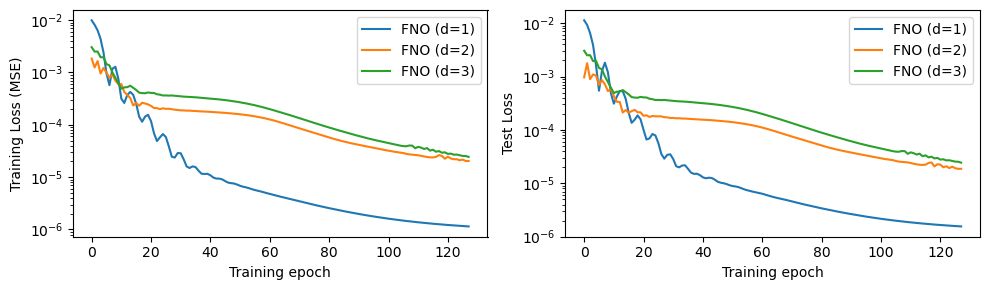

In [89]:
# approx 3500 

train_NN_d1 = [0.05047412512179177, 0.005338965171876435, 0.002961041374454418, 0.002134455699258699, 0.0017030105138054262, 0.0014645134886870016, 0.0013015415662756334, 0.0011948715635718633, 0.0010847460272578667, 0.0010108480368776678, 0.0009345761142097986, 0.0008714098232583358, 0.0008472824265481904, 0.0008012011553196666, 0.0007756604889157013, 0.00072335144236254, 0.0006814083440426307, 0.0006684665433847561, 0.0006409029055458421, 0.0006295366922411352, 0.0005853955937289776, 0.0005615933836312392, 0.000551613062830606, 0.0005252315800484772, 0.0005087063870562885, 0.0004787409158710104, 0.00048726877643135737, 0.000452964004720203, 0.0004530722765663925, 0.00041318061770513083, 0.00040273295655004826, 0.0003925554214779717, 0.00037893826195683616, 0.00038412112357596366, 0.000351181610032934, 0.00035935407504439354, 0.00031771371308982803, 0.0003341220821871852, 0.00031593904965960135, 0.00030942738577813055, 0.0002957876604341436, 0.0002778472212062647, 0.0002739906723525984, 0.00026515511406334833, 0.00025654450767503405, 0.00024270218105252401, 0.00025943054284792964, 0.0002372856979491189, 0.00023190060388655044, 0.00022211167883002557, 0.00022588585656754172, 0.00026008392188277166, 0.00026825858787140954, 0.00021596578545331096, 0.00023223410467975415, 0.00020151555425120302, 0.00019293831568435192, 0.00018486348366982734, 0.0001764311743430041, 0.00018212337762144252, 0.00019266905320154576, 0.00018486847357752806, 0.0001784005656260818, 0.00021561181179444806, 0.00019699809966438735, 0.00021079718611032987, 0.00017779935128951015, 0.00017934746014921425, 0.000163349680056294, 0.00018047423747283084, 0.00018936038395622745, 0.00017146213087051784, 0.00017105254566838714, 0.00015954818473591542, 0.0001437000110644686, 0.00017737402539261474, 0.00016192812696457483, 0.00016652694466756657, 0.00015476122406163576, 0.00015067759005223008, 0.00013828474780334195, 0.00016935196477928772, 0.00015943347618583805, 0.00016688691007752472, 0.00013522724125673098, 0.00017589000218812053, 0.0001386749625873143, 0.00013508947561674105, 0.00013415740823592598, 0.00013552997132557302, 0.00015621590626743945, 0.00012374083696788427, 0.000143739696096208, 0.00017716093288282325, 0.0001234874177428607, 0.00013475390075585054, 0.00013446877220793304, 0.00012245787995477888, 0.00011642436878061674, 0.0001135589857137977, 0.00012133762860545315, 0.0001419817455406211, 0.00010961784741644246, 0.00012184014555644423, 0.00010572113079923348, 0.00013816220850388234, 0.00011479599911231511, 0.00013674410211723836, 0.00011945504537344768, 0.00012977496142131992, 0.00013949551976111252, 0.00011477443261425763, 0.00010636470492150133, 0.00010617005752395086, 8.915298391142502e-05, 0.00010897353198603154, 0.00013194682483467308, 0.000130385388659376, 0.00010679413739685864, 0.0001070007726341898, 0.0001293373759556114, 0.00014210053002618504, 8.704655752248633e-05, 0.00010518916161135376, 0.0001061587438296276, 0.00011012235979880922, 0.00010093369550864176, 0.0001032793992495639]
train_NN_d2 = []
train_NN_d3 = []

train_FNO_d1 = [0.009918379597365856, 0.008130304981023073, 0.0063901355024427176, 0.004387421766296029, 0.00239541195333004, 0.0009604628139641136, 0.0005715938023058698, 0.001177404832560569, 0.0012817959650419652, 0.0007497845217585564, 0.000315596247673966, 0.00026158893888350576, 0.000370656416635029, 0.0004247503529768437, 0.0003728949523065239, 0.0002522270515328273, 0.0001430774063919671, 0.00011453950719442219, 0.00014335932792164385, 0.00015517959400312975, 0.000117571595183108, 6.914113328093663e-05, 4.8957897888612933e-05, 5.746905844716821e-05, 6.656250116066076e-05, 5.841079655510839e-05, 3.871048284054268e-05, 2.4550664420530666e-05, 2.37002477661008e-05, 2.887819937313907e-05, 2.862487599486485e-05, 2.192712781834416e-05, 1.5991377949831076e-05, 1.4944567737984471e-05, 1.6064247120084474e-05, 1.555304515932221e-05, 1.3292680705490056e-05, 1.1624476428551134e-05, 1.1503360838105436e-05, 1.1585238553379895e-05, 1.0849991213035537e-05, 9.829626833379734e-06, 9.397277608513832e-06, 9.373939974466339e-06, 9.047738785739057e-06, 8.377024187211646e-06, 7.857503533159615e-06, 7.6721521509171e-06, 7.546887445641914e-06, 7.214862080218154e-06, 6.832894769104314e-06, 6.563125225511612e-06, 6.3816357851465e-06, 6.15329599895631e-06, 5.888493660677341e-06, 5.667343657478341e-06, 5.49383184988983e-06, 5.3203343668428715e-06, 5.127325266585103e-06, 4.951113396600704e-06, 4.793239440914476e-06, 4.634360948330141e-06, 4.4708745008392725e-06, 4.317698312661378e-06, 4.183481678410317e-06, 4.05259902436228e-06, 3.9204494441946736e-06, 3.7932669556539622e-06, 3.6728812347064377e-06, 3.5572285241869395e-06, 3.44355282777542e-06, 3.3354647257510806e-06, 3.2348293643735815e-06, 3.1380747032017098e-06, 3.0444419962805114e-06, 2.954501042040647e-06, 2.867577450160752e-06, 2.783903710223967e-06, 2.703764721445623e-06, 2.627558160384069e-06, 2.5554925286996877e-06, 2.486406970092503e-06, 2.4196813228627434e-06, 2.3557115582661936e-06, 2.2942665509617655e-06, 2.2351247253027395e-06, 2.1787946025142446e-06, 2.1253085833450314e-06, 2.0741999833262525e-06, 2.0252927015462774e-06, 1.9784281448664842e-06, 1.9333913314767415e-06, 1.8901986891251e-06, 1.8489867557036632e-06, 1.8097362612934376e-06, 1.7722620668791933e-06, 1.7364558289045817e-06, 1.7021934581862297e-06, 1.6693412021595577e-06, 1.6378622831325629e-06, 1.607801664249564e-06, 1.5791443956914009e-06, 1.5517888414251502e-06, 1.5256297274390818e-06, 1.5005959426162008e-06, 1.4766278013667034e-06, 1.4536732919623319e-06, 1.4317166687760619e-06, 1.410748666330619e-06, 1.3907260836276691e-06, 1.3715743421016668e-06, 1.3532196589949308e-06, 1.3356194585867343e-06, 1.318753845680476e-06, 1.3026090641687915e-06, 1.2871594776697748e-06, 1.2723628515232122e-06, 1.258173710994015e-06, 1.2445596553334326e-06, 1.2314907849031442e-06, 1.2189498193038162e-06, 1.206913680107391e-06, 1.195367474338127e-06, 1.184287270916684e-06, 1.1736507303794497e-06, 1.1634446650532482e-06, 1.153664811681665e-06, 1.144319412560435e-06]
train_FNO_d2 = [0.0030394127825275064, 0.002501877606846392, 0.0025117744226008654, 0.001953135884832591, 0.0019538793130777776, 0.001445353904273361, 0.0013633423368446529, 0.0010005313961301, 0.0007881934579927474, 0.0006266373966354877, 0.0004906733811367303, 0.000519154971698299, 0.0005236589931882918, 0.0005577817792072892, 0.000509809295181185, 0.00046245395787991583, 0.0004116186319151893, 0.00040299788815900683, 0.00040033522236626595, 0.000414565991377458, 0.0004069950809935108, 0.00040467614599037915, 0.000383319886168465, 0.0003762798442039639, 0.00036312777956482023, 0.00036393744812812656, 0.0003611789725255221, 0.0003634604508988559, 0.0003586322854971513, 0.00035400093474891037, 0.00034790561767295003, 0.0003454958787187934, 0.0003431314980844036, 0.0003413065569475293, 0.0003385509626241401, 0.000335271266521886, 0.000331568910041824, 0.0003277367795817554, 0.00032485698466189206, 0.00032157014356926084, 0.00031800080614630133, 0.00031381881854031235, 0.00030973479442764074, 0.00030536613485310227, 0.00030078343115746975, 0.0002962510479846969, 0.0002913123316830024, 0.0002859920059563592, 0.0002805475814966485, 0.00027494426467455924, 0.00026906028506346047, 0.0002629843511385843, 0.0002566390612628311, 0.0002499710171832703, 0.00024316264170920476, 0.00023613399389432743, 0.00022889181855134666, 0.0002215737331425771, 0.00021410554472822696, 0.00020666718046413735, 0.00019922928913729265, 0.0001918902198667638, 0.00018467907648300752, 0.00017769730038708076, 0.00017087539163185284, 0.00016431780386483297, 0.0001579016025061719, 0.00015172480925684795, 0.00014564157754648477, 0.00013978166680317372, 0.00013402284457697533, 0.0001285207508772146, 0.00012316028369241394, 0.00011808213457698002, 0.00011317892131046392, 0.00010855816071853042, 0.00010412423216621391, 9.99514122668188e-05, 9.596710879122838e-05, 9.221578147844411e-05, 8.864616029313765e-05, 8.527153840987012e-05, 8.205437916330993e-05, 7.89908917795401e-05, 7.606209692312405e-05, 7.325638944166712e-05, 7.058113988023251e-05, 6.801524432376027e-05, 6.55725016258657e-05, 6.324664354906417e-05, 6.1035467297188e-05, 5.894374044146389e-05, 5.696881271433085e-05, 5.5111133406171575e-05, 5.336648064258043e-05, 5.173084537091199e-05, 5.0207763706566766e-05, 4.880407686869148e-05, 4.7519495637970977e-05, 4.63011037936667e-05, 4.501972762227524e-05, 4.3608293708530255e-05, 4.221088602207601e-05, 4.098794852325227e-05, 3.995506267528981e-05, 3.9146567360148765e-05, 3.8942813262110576e-05, 4.0178128983825445e-05, 4.001301567768678e-05, 3.5608776670414954e-05, 3.7962534406688064e-05, 3.661164009827189e-05, 3.4544271329650655e-05, 3.5833036235999316e-05, 3.2136977097252384e-05, 3.338068472658051e-05, 3.0547379537892994e-05, 3.144128004350932e-05, 2.9262892894621473e-05, 2.9820292184012942e-05, 2.778395082714269e-05, 2.8144522730144672e-05, 2.6836168217414524e-05, 2.697733634704491e-05, 2.615543780848384e-05, 2.5444724087719806e-05, 2.533269434934482e-05, 2.4333705368917435e-05]
train_FNO_d3 = [0.0018445670139044523, 0.0012480519944801927, 0.0016497005708515644, 0.0009532390977256, 0.001219521975144744, 0.000991862965747714, 0.0007931729487609118, 0.0009067776845768094, 0.0007013332506176084, 0.000594216980971396, 0.0006001206638757139, 0.00042366627894807607, 0.0003739427629625425, 0.0003261591191403568, 0.00023399148631142452, 0.0002606472553452477, 0.0002313169970875606, 0.000263715090113692, 0.0002553238591644913, 0.00024519218277418986, 0.00022947791148908436, 0.00020925184071529657, 0.00020824219973292202, 0.00019923823128920048, 0.00020626185141736642, 0.00020164399029454216, 0.0002027869486482814, 0.00019870926917064935, 0.0001944837931660004, 0.0001920473951031454, 0.00018855504458770156, 0.00018823250866262242, 0.0001862993522081524, 0.0001865455851657316, 0.00018447426555212587, 0.00018364619609201327, 0.0001814901625039056, 0.00018055505643133074, 0.00017909148300532252, 0.00017808033589972183, 0.00017662264872342348, 0.000175355926330667, 0.00017378506163368002, 0.00017228577053174376, 0.0001705726608633995, 0.00016895629960345104, 0.0001671725549385883, 0.00016533104644622654, 0.00016328415949828923, 0.00016118177882162854, 0.00015889606584096327, 0.00015648121188860387, 0.00015386710583698004, 0.00015111414541024715, 0.00014816639304626733, 0.0001450231793569401, 0.00014168897905619815, 0.00013817729632137343, 0.0001344904230791144, 0.00013061353092780337, 0.0001265903702005744, 0.0001224320731125772, 0.0001181474290206097, 0.00011379015995771624, 0.00010940840365947224, 0.00010503695011720993, 0.00010075462705572136, 9.661171861807816e-05, 9.265802873414941e-05, 8.892947880667634e-05, 8.541694114683196e-05, 8.21146895759739e-05, 7.896051465650089e-05, 7.593466216349043e-05, 7.298951459233649e-05, 7.012432251940481e-05, 6.734012640663423e-05, 6.464504986070096e-05, 6.205775935086422e-05, 5.9586689530988224e-05, 5.725012488255743e-05, 5.505535409611184e-05, 5.301419150782749e-05, 5.1127821279806085e-05, 4.93971019750461e-05, 4.7810601245146245e-05, 4.63531741843326e-05, 4.5001313992543146e-05, 4.373535011836793e-05, 4.253875704307575e-05, 4.140178862144239e-05, 4.031490607303567e-05, 3.927046236640308e-05, 3.8259355278569274e-05, 3.727707553480286e-05, 3.63221624866128e-05, 3.539505269145593e-05, 3.449740324867889e-05, 3.3630394682404585e-05, 3.279515658505261e-05, 3.199426282662898e-05, 3.123735950794071e-05, 3.055569686694071e-05, 3.001466757268645e-05, 2.957835476991022e-05, 2.8845879569416866e-05, 2.784775642794557e-05, 2.7224297809880227e-05, 2.691193913051393e-05, 2.662583483470371e-05, 2.617661448311992e-05, 2.548807424318511e-05, 2.4775906240392942e-05, 2.424964986857958e-05, 2.3900177438918035e-05, 2.3782098651281558e-05, 2.440907610434806e-05, 2.635329929034924e-05, 2.5372047275595833e-05, 2.24770219574566e-05, 2.4625790501886513e-05, 2.271060202474473e-05, 2.2048900063964538e-05, 2.2002200239512604e-05, 2.0982371097488794e-05, 2.168340051866835e-05, 2.0330899133114144e-05, 2.0313579625508282e-05]


test_NN_d1 = [0.007602650170715954, 0.0036533716528748088, 0.002410772346103421, 0.0018327074805991007, 0.0015848037571861192, 0.0014183654969271559, 0.0012180287695418186, 0.0012038102230200402, 0.0010427511386716596, 0.0009494125216196363, 0.0008924192023606827, 0.0008577735906538481, 0.0008759736441648923, 0.0007552951977301676, 0.0008490220240603846, 0.0007506104078716957, 0.0006421988588184691, 0.000620643885877843, 0.000917110032437799, 0.0006380869577137325, 0.0005678660684050276, 0.0005196949686461057, 0.0005003302581966497, 0.0005416366755245969, 0.0004751855203022178, 0.00045525247696787124, 0.0004529468177889402, 0.000539985563731394, 0.0004265102101131701, 0.0004112574142009879, 0.00043232960608572914, 0.00035646264754737227, 0.000366434636257159, 0.00037975035733185143, 0.0003892589257492756, 0.0003343855854696953, 0.00029705243650823826, 0.00032512550555671065, 0.0003398868900078993, 0.00036770662364478293, 0.00026677892422482657, 0.00025957838582913747, 0.00023661091444619859, 0.00024050519725558563, 0.0002405554640482968, 0.00027882707609723387, 0.00022301664844585152, 0.00025838368030515715, 0.00022462700592139017, 0.00032250298402057234, 0.00023275561062081787, 0.00030786511622584215, 0.00021562517325107294, 0.00022721804718737706, 0.00030884878092015593, 0.00024081197737429582, 0.00016678006012135974, 0.00020010693249507595, 0.0001946371194208041, 0.00019089149897739003, 0.00019600598898250612, 0.00017123453681751224, 0.0002093041257467121, 0.00044563624228780664, 0.0002291370071291637, 0.00028046622845487524, 0.0001963461086583825, 0.00024157297090054132, 0.00016710065224637778, 0.0002484892924817709, 0.00016066185847963564, 0.00013993852973306694, 0.00016756527027330146, 0.00016226485156669066, 0.00016834712117158165, 0.00012278800680248355, 0.000210809608688578, 0.00013000799607163152, 0.00012355384779556724, 0.00012599936151393474, 0.00022011777932325806, 0.0001472824962827592, 0.0001325322479645435, 0.00010784034160538935, 0.00020407440919930543, 0.0001429205831999962, 0.0001330915832883105, 0.00018817558660745047, 0.00016475787337045546, 0.0003428622148931027, 0.00012962739744510216, 0.00018184495498784462, 0.0001558625327351575, 0.00010154536441684915, 0.000170251530317518, 0.0001251327591419865, 0.00017427064057511208, 0.00019818063279112368, 0.00011521042268633697, 0.00019370731360350663, 0.00013784737865745017, 9.142988990508736e-05, 7.57998266355851e-05, 8.87196449464402e-05, 9.214725399103302e-05, 8.122121037628788e-05, 0.0001465029412289508, 0.00021881192962889775, 0.00010820241116632061, 8.314979808906523e-05, 0.0002178717382216396, 9.784327546815173e-05, 0.0001077726024400013, 9.014649213685725e-05, 8.850818323061016e-05, 8.492377953818785e-05, 0.00011264821380161897, 7.229697523423685e-05, 9.166120435111225e-05, 0.00019115115215894405, 0.00014916072541382164, 8.937914837868168e-05, 7.94834133837587e-05, 0.00017076224881188513, 8.156882708695214e-05, 0.00010067677906660648, 7.819477916480257e-05, 0.0001959572893191272]
test_NN_d2 = []
test_NN_d3 = []

test_FNO_d1 = [0.011304153129458427, 0.009266939014196396, 0.006510550621896982, 0.0038844773080199957, 0.0016283298609778285, 0.0005420551751740277, 0.0012771276524290442, 0.0018150110263377428, 0.0012070398079231381, 0.0004900278290733695, 0.00031011318787932396, 0.00041923669050447643, 0.0005364165990613401, 0.0005321927019394934, 0.0003806532477028668, 0.00020944111747667193, 0.0001356556749669835, 0.00015470841026399285, 0.00018661731155589223, 0.00015789060853421688, 0.00010046812531072646, 6.601311906706542e-05, 6.92397152306512e-05, 8.365406392840669e-05, 7.874977745814249e-05, 5.6554286857135594e-05, 3.536134317982942e-05, 2.8913818823639303e-05, 3.405984534765594e-05, 3.4903830965049565e-05, 2.8481659683166072e-05, 2.0855099137406796e-05, 1.9861252440023236e-05, 2.1507161363842897e-05, 2.1724144971813075e-05, 1.8620581613504328e-05, 1.5823436115169898e-05, 1.4985389498178847e-05, 1.510151651018532e-05, 1.4195379662851337e-05, 1.2921643246954773e-05, 1.2394121768011246e-05, 1.271678411285393e-05, 1.2535747373476624e-05, 1.1690392057062127e-05, 1.0686017958505545e-05, 1.0252031643176451e-05, 1.0007508535636589e-05, 9.651717846281826e-06, 9.180842425848823e-06, 8.879601409716997e-06, 8.714383511687629e-06, 8.467028237646446e-06, 8.067927410593256e-06, 7.673507752770092e-06, 7.3844930739142e-06, 7.142763024603482e-06, 6.922954980836948e-06, 6.728206699335715e-06, 6.557446340593742e-06, 6.368306912918342e-06, 6.136404408607632e-06, 5.889944986847695e-06, 5.6677718021092005e-06, 5.4767701840319205e-06, 5.308228537614923e-06, 5.1596289267763495e-06, 5.020774096919922e-06, 4.876641014561756e-06, 4.720128799817758e-06, 4.558984983304981e-06, 4.4053354031348135e-06, 4.26519500251743e-06, 4.139453267271165e-06, 4.026075203000801e-06, 3.91777757613454e-06, 3.8082200717326486e-06, 3.697428155646776e-06, 3.587703304219758e-06, 3.4841666547436034e-06, 3.3889361930050654e-06, 3.3000605981214903e-06, 3.2170055419555865e-06, 3.136645773338387e-06, 3.0561832318198867e-06, 2.9769723823847016e-06, 2.9015068321314175e-06, 2.8307501906965626e-06, 2.7647847673506476e-06, 2.703247673707665e-06, 2.643862444529077e-06, 2.5854460545815527e-06, 2.5283234208473004e-06, 2.4731421035539825e-06, 2.4208879949583206e-06, 2.371987875449122e-06, 2.3262828108272515e-06, 2.2826452550361864e-06, 2.240219146187883e-06, 2.1989412744005676e-06, 2.1590972210105974e-06, 2.121077159245033e-06, 2.0851198314630892e-06, 2.051235242106486e-06, 2.019005478359759e-06, 1.987986479434767e-06, 1.9579329091357067e-06, 1.9290123418613803e-06, 1.9014088366020587e-06, 1.8752068626781693e-06, 1.85030671673303e-06, 1.82648989266454e-06, 1.8035881339528714e-06, 1.7815127648646012e-06, 1.7603287005840684e-06, 1.7400834622094408e-06, 1.720788191050815e-06, 1.7023630789481103e-06, 1.684697053860873e-06, 1.6676808627380524e-06, 1.6512814227098715e-06, 1.6355293155356776e-06, 1.6204679695874802e-06, 1.6060846519394545e-06, 1.592329340383003e-06, 1.5791481473570457e-06, 1.5665050341340248e-06, 1.5544264897471294e-06]
test_FNO_d2 = [0.0030394127825275064, 0.002501877606846392, 0.0025117744226008654, 0.001953135884832591, 0.0019538793130777776, 0.001445353904273361, 0.0013633423368446529, 0.0010005313961301, 0.0007881934579927474, 0.0006266373966354877, 0.0004906733811367303, 0.000519154971698299, 0.0005236589931882918, 0.0005577817792072892, 0.000509809295181185, 0.00046245395787991583, 0.0004116186319151893, 0.00040299788815900683, 0.00040033522236626595, 0.000414565991377458, 0.0004069950809935108, 0.00040467614599037915, 0.000383319886168465, 0.0003762798442039639, 0.00036312777956482023, 0.00036393744812812656, 0.0003611789725255221, 0.0003634604508988559, 0.0003586322854971513, 0.00035400093474891037, 0.00034790561767295003, 0.0003454958787187934, 0.0003431314980844036, 0.0003413065569475293, 0.0003385509626241401, 0.000335271266521886, 0.000331568910041824, 0.0003277367795817554, 0.00032485698466189206, 0.00032157014356926084, 0.00031800080614630133, 0.00031381881854031235, 0.00030973479442764074, 0.00030536613485310227, 0.00030078343115746975, 0.0002962510479846969, 0.0002913123316830024, 0.0002859920059563592, 0.0002805475814966485, 0.00027494426467455924, 0.00026906028506346047, 0.0002629843511385843, 0.0002566390612628311, 0.0002499710171832703, 0.00024316264170920476, 0.00023613399389432743, 0.00022889181855134666, 0.0002215737331425771, 0.00021410554472822696, 0.00020666718046413735, 0.00019922928913729265, 0.0001918902198667638, 0.00018467907648300752, 0.00017769730038708076, 0.00017087539163185284, 0.00016431780386483297, 0.0001579016025061719, 0.00015172480925684795, 0.00014564157754648477, 0.00013978166680317372, 0.00013402284457697533, 0.0001285207508772146, 0.00012316028369241394, 0.00011808213457698002, 0.00011317892131046392, 0.00010855816071853042, 0.00010412423216621391, 9.99514122668188e-05, 9.596710879122838e-05, 9.221578147844411e-05, 8.864616029313765e-05, 8.527153840987012e-05, 8.205437916330993e-05, 7.89908917795401e-05, 7.606209692312405e-05, 7.325638944166712e-05, 7.058113988023251e-05, 6.801524432376027e-05, 6.55725016258657e-05, 6.324664354906417e-05, 6.1035467297188e-05, 5.894374044146389e-05, 5.696881271433085e-05, 5.5111133406171575e-05, 5.336648064258043e-05, 5.173084537091199e-05, 5.0207763706566766e-05, 4.880407686869148e-05, 4.7519495637970977e-05, 4.63011037936667e-05, 4.501972762227524e-05, 4.3608293708530255e-05, 4.221088602207601e-05, 4.098794852325227e-05, 3.995506267528981e-05, 3.9146567360148765e-05, 3.8942813262110576e-05, 4.0178128983825445e-05, 4.001301567768678e-05, 3.5608776670414954e-05, 3.7962534406688064e-05, 3.661164009827189e-05, 3.4544271329650655e-05, 3.5833036235999316e-05, 3.2136977097252384e-05, 3.338068472658051e-05, 3.0547379537892994e-05, 3.144128004350932e-05, 2.9262892894621473e-05, 2.9820292184012942e-05, 2.778395082714269e-05, 2.8144522730144672e-05, 2.6836168217414524e-05, 2.697733634704491e-05, 2.615543780848384e-05, 2.5444724087719806e-05, 2.533269434934482e-05, 2.4333705368917435e-05]
test_FNO_d3 = [0.0009651236468926072, 0.0017742926720529795, 0.0008933998178690672, 0.0010954493191093206, 0.0010412990814074874, 0.0006988105596974492, 0.0008540858398191631, 0.0007155544590204954, 0.0005326708196662366, 0.0005868389853276312, 0.00042968851630575955, 0.0003365255251992494, 0.00033352000173181295, 0.00021164935606066138, 0.00023553961364086717, 0.0002097686956403777, 0.000224767965846695, 0.00023722904734313488, 0.00021460186690092087, 0.00021299229410942644, 0.00018365099094808102, 0.00018793446361087263, 0.00017505374853499234, 0.00018222197832074016, 0.00017971688066609204, 0.000179556300281547, 0.0001790770038496703, 0.0001728027855278924, 0.0001719557330943644, 0.00016713092918507755, 0.0001675894163781777, 0.00016479723853990436, 0.00016516339383088052, 0.00016330205835402012, 0.0001629704493097961, 0.00016116203914862126, 0.00016002649499569088, 0.0001588905870448798, 0.0001580914540681988, 0.00015707293641753495, 0.00015585623623337597, 0.00015458182315342128, 0.0001532782189315185, 0.00015184270159807056, 0.00015030382201075554, 0.0001487826375523582, 0.0001472350995754823, 0.00014550179184880108, 0.00014365080278366804, 0.00014169487985782325, 0.00013967770792078227, 0.00013745010073762387, 0.00013512172154150903, 0.0001326312922174111, 0.00012998362944927067, 0.0001271157816518098, 0.00012410097406245768, 0.00012094395060557872, 0.00011761894711526111, 0.00011415134213166311, 0.00011055628419853747, 0.00010686034511309117, 0.00010308268974767998, 9.926556958816946e-05, 9.544922795612365e-05, 9.167789539787918e-05, 8.800882642390206e-05, 8.449190499959514e-05, 8.116209210129455e-05, 7.8005381510593e-05, 7.502295193262398e-05, 7.218483369797468e-05, 6.944382766960189e-05, 6.679396028630435e-05, 6.421397847589105e-05, 6.17236437392421e-05, 5.9328194765839726e-05, 5.7032491895370185e-05, 5.485047586262226e-05, 5.278414755593985e-05, 5.084136500954628e-05, 4.902137879980728e-05, 4.732925663120113e-05, 4.5760676584905013e-05, 4.431476554600522e-05, 4.298036219552159e-05, 4.1747258364921436e-05, 4.059669663547538e-05, 3.952022598241456e-05, 3.8504287658724934e-05, 3.753901182790287e-05, 3.661110531538725e-05, 3.5713099350687116e-05, 3.483924956526607e-05, 3.3983091270783916e-05, 3.314660716569051e-05, 3.232702874811366e-05, 3.15292454615701e-05, 3.075584027101286e-05, 3.000868673552759e-05, 2.9296252250787802e-05, 2.8637876312131993e-05, 2.8089183615520597e-05, 2.7684745873557404e-05, 2.7110983864986338e-05, 2.6149511541007087e-05, 2.547904477978591e-05, 2.5186345737893134e-05, 2.4951197701739147e-05, 2.4591094188508578e-05, 2.3964968931977637e-05, 2.321927240700461e-05, 2.2631717001786456e-05, 2.2238269593799487e-05, 2.202658106398303e-05, 2.2314918169286102e-05, 2.399004551989492e-05, 2.455801222822629e-05, 2.06875065487111e-05, 2.2776519472245127e-05, 2.2256366719375364e-05, 1.998341758735478e-05, 2.0827816115343012e-05, 1.9243692804593593e-05, 2.048567148449365e-05, 1.9150720618199557e-05, 1.8638256733538583e-05, 1.8647035176400095e-05]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,3))

ax1.semilogy(train_NN_d1, "--", label="NN (d=1)")
ax1.semilogy(train_NN_d2, "--", label="NN (d=2)")
ax1.semilogy(train_NN_d3, "--", label="NN (d=3)")

ax1.semilogy(train_FNO_d1, label="FNO (d=1)")
ax1.semilogy(train_FNO_d2, label="FNO (d=2)")
ax1.semilogy(train_FNO_d3, label="FNO (d=3)")
ax1.set_xlabel("Training epoch")
ax1.set_ylabel("Training Loss (MSE)")
ax1.legend()

ax1.semilogy(train_FNO_d1, "--", label="NN (d=1)")
ax1.semilogy(train_FNO_d2, "--", label="NN (d=2)")
ax1.semilogy(train_FNO_d3, "--", label="NN (d=3)")

ax2.semilogy(test_FNO_d1, label="FNO (d=1)")
ax2.semilogy(test_FNO_d2, label="FNO (d=2)")
ax2.semilogy(test_FNO_d3, label="FNO (d=3)")
ax2.set_xlabel("Training epoch")
ax2.set_ylabel("Test Loss")
ax2.legend()

fig.tight_layout()

In [47]:
k = 10
print(param_samples[k, :])

test_input = fno_input_train[k:k+1, :, :, :]

prediction = fno.forward(test_input).reshape((discretization, discretization)).detach().numpy()
ground_truth = fno_output_train[k, :, :, :].reshape((discretization, discretization)).detach().numpy()

vmin = min(np.min(prediction), np.min(ground_truth))
vmax = max(np.max(prediction), np.max(ground_truth))

print(prediction.shape)
print(ground_truth.shape)

xx, yy = np.meshgrid(x1_points, x2_points)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

im1 = ax1.scatter(xx, yy, c=prediction, cmap='viridis', vmin=vmin, vmax=vmax)
ax1.set_title("FNO prediction")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
plt.colorbar(im1)
ax1.set_aspect(1)
im2 = ax2.scatter(xx, yy, c=ground_truth, cmap='viridis', vmin=vmin, vmax=vmax)
ax2.set_title("Ground truth")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
plt.colorbar(im2)
ax2.set_aspect(1)
err = np.abs(ground_truth-prediction)
im3 = ax3.scatter(xx, yy, c=err, cmap='binary')
ax3.set_title("Absolute error")
ax3.set_xlabel("X1")
ax3.set_ylabel("X2")
plt.colorbar(im3)
ax3.set_aspect(1)
print("Max point relative error = ", np.max(err)/(vmax-vmin))
fig.tight_layout()

IndexError: index 10 is out of bounds for dimension 0 with size 1

tensor([[-0.0506]])
(32, 32)
(32, 32)
Max point relative rror =  0.03010761


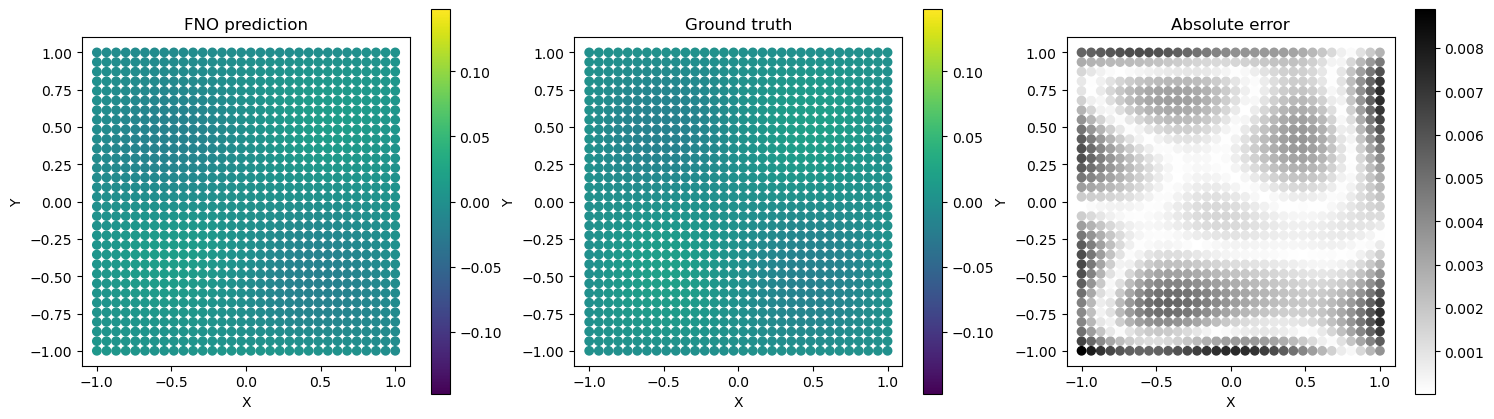

In [46]:
n_samples = 1

param_samples = torch.rand((n_samples, d))*(mu_max - mu_min) + mu_min
print(param_samples)

fno_input_positions = torch.tile(position_grid.reshape((1, discretization**2, 2)), (n_samples, 1, 1))
# print(fno_input_positions.shape)
fno_input_params = torch.tile(param_samples.reshape(n_samples, 1, d), (1, discretization**2, 1))
# print(fno_input_params.shape)
fno_input_vectors = torch.concatenate((fno_input_positions, fno_input_params), axis=-1).reshape(n_samples*discretization*discretization, 2+d)
# print(fno_input_vectors.shape)

fno_input_train = torch.concatenate(
    (
        u0(np.transpose(fno_input_vectors)).reshape((n_samples, discretization, discretization, 1)), 
        fno_input_vectors[:, 0].reshape((n_samples, discretization, discretization, 1)),
        fno_input_vectors[:, 1].reshape((n_samples, discretization, discretization, 1))
    ), 
    axis=-1)
fno_output_train = u(final_time, np.transpose(fno_input_vectors)).reshape((n_samples, discretization, discretization, 1))


prediction = fno.forward(fno_input_train).reshape((discretization, discretization)).detach().numpy()
ground_truth = fno_output_train[0, :, :, :].reshape((discretization, discretization)).detach().numpy()

print(prediction.shape)
print(ground_truth.shape)

xx, yy = np.meshgrid(x1_points, x2_points)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

im1 = ax1.scatter(xx, yy, c=prediction, cmap='viridis', vmin=vmin, vmax=vmax)
ax1.set_title("FNO prediction")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
plt.colorbar(im1)
ax1.set_aspect(1)
im2 = ax2.scatter(xx, yy, c=ground_truth, cmap='viridis', vmin=vmin, vmax=vmax)
ax2.set_title("Ground truth")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
plt.colorbar(im2)
ax2.set_aspect(1)
err = np.abs(ground_truth-prediction)
im3 = ax3.scatter(xx, yy, c=err, cmap='binary')
ax3.set_title("Absolute error")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
plt.colorbar(im3)
ax3.set_aspect(1)
print("Max point relative rror = ", np.max(err)/(vmax-vmin))

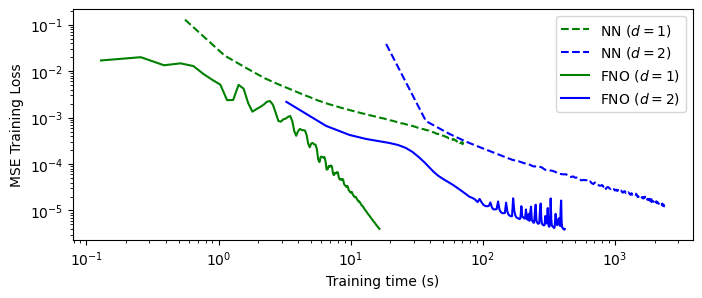

In [68]:
# NN

losses_NN_d1 = np.array([0.12860536691732705, 0.021514792751986533, 0.011100359843112528, 0.007067454658681527, 0.005324550991645083, 0.0042982565792044625, 0.0035747937072301283, 0.0030557587306248024, 0.00268607736506965, 0.002375939133344218, 0.0021615836449200287, 0.0019852141340379603, 0.0018550853492342867, 0.0017379719502059743, 0.0016443286804133095, 0.0015603059146087617, 0.0014905776333762333, 0.0014272114058258012, 0.001368637676932849, 0.0013177731889300048, 0.0012705536573776044, 0.0012285306365811266, 0.001199930462462362, 0.0011659746305667795, 0.0011229208976146765, 0.0010942235385300592, 0.0010617648731567897, 0.0010373429067840334, 0.0010236654525215272, 0.0009898680764308665, 0.0009732332582643721, 0.000956073770794319, 0.0009301433965447359, 0.0009038211464940105, 0.0008842605602694675, 0.0008670217830513138, 0.0008582134178141132, 0.0008360816827917006, 0.0008246070756285917, 0.0008036647232074756, 0.000788827794167446, 0.0007810454299033154, 0.0007590633322251961, 0.0007478173065464944, 0.000746143839933211, 0.0007304923092306126, 0.0007154186896514148, 0.0007057920847728383, 0.0006919320258020889, 0.0006841651811555494, 0.0006738882802892476, 0.0006632515287492424, 0.0006588231844943948, 0.0006475327900261618, 0.0006358635509968735, 0.0006279433509916998, 0.000614606589806499, 0.0006048561153875198, 0.0006002134905429557, 0.0005893504348932765, 0.0005802359191875439, 0.0005733501420763787, 0.0005636894929921255, 0.0005656454904965358, 0.0005559497949434444, 0.000542846777534578, 0.0005424848422990181, 0.0005336526355677051, 0.0005288592456054175, 0.0005271869213174796, 0.0005107308734295657, 0.0005044852950959466, 0.000502110453453497, 0.000495409873110475, 0.0004868949981755577, 0.0004780227918672608, 0.0004787303860211978, 0.00046915602433728054, 0.00045941553071315866, 0.0004483600405364996, 0.000447449700004654, 0.0004491832423809683, 0.0004369257549114991, 0.00042978789315384347, 0.00042822022624022793, 0.0004191866628389107, 0.00041070366751227994, 0.00041337343463965226, 0.00040844252362148836, 0.00040818330853653606, 0.00040584956150269136, 0.00039753265264153015, 0.00039500608363596257, 0.00038610478077316657, 0.00038087269240349997, 0.00037958502252877224, 0.0003747280625248095, 0.00036816622014157474, 0.00035784967985819094, 0.00035707963252207264, 0.0003581545934139285, 0.00034929684807138983, 0.0003367255376360845, 0.000333598811266711, 0.00033361332134518307, 0.0003314622626930941, 0.0003464897054072935, 0.0003430119886616012, 0.0003401179965294432, 0.00032829771043907385, 0.0003259591157984687, 0.00032634296258038376, 0.00031376603692478966, 0.000311584864903125, 0.00030075346694502514, 0.0002934901713160798, 0.00029244158758956473, 0.0003041862728423439, 0.0002986122162838001, 0.0002882389890146442, 0.000281837395959883, 0.00028426457538444083, 0.0002941496823041234, 0.0002832577247318113, 0.0002725153781284462, 0.00029310787613212597, 0.0002682928170543164, 0.0002688606564333895])
epoch_time_NN_d1 = 0.5572919715195894

losses_NN_d2 = np.array([0.038398604481699294, 0.0008414059753931724, 0.0004479656234934737, 0.0003057472573004816, 0.0002362405616054275, 0.00019308358722014418, 0.00016353138622093866, 0.00014052984039381045, 0.000123141964536444, 0.00011559024906659943, 0.00010501525198947093, 9.8710932363133e-05, 8.889720540139479e-05, 8.9278366885992e-05, 8.510656742544143e-05, 7.500605181576248e-05, 7.317703069276149e-05, 7.182694918839161e-05, 6.814597902859987e-05, 6.29733811123856e-05, 6.0831823482487835e-05, 5.9923161110475576e-05, 6.030238710508229e-05, 5.439491510372818e-05, 5.264372428470665e-05, 5.4215871564622375e-05, 5.0679181978097176e-05, 5.1458616908917065e-05, 4.793797441138281e-05, 4.4363033190109036e-05, 4.541344796749058e-05, 4.516093225603868e-05, 4.4408634650494605e-05, 4.0609512499401035e-05, 4.217767195768829e-05, 3.85121406409894e-05, 3.7094741582421875e-05, 4.003293000209851e-05, 3.6346967537070896e-05, 3.6506160450144876e-05, 3.413653472961187e-05, 3.4115743435592094e-05, 3.5307328609235356e-05, 3.242641811596059e-05, 3.434312320216293e-05, 2.9148556478730825e-05, 3.1748934285147357e-05, 3.182960096204113e-05, 2.98560185303387e-05, 2.9055307521730356e-05, 3.0921128125527275e-05, 2.892139291432727e-05, 2.880406422711701e-05, 2.689262099231371e-05, 2.816290686880052e-05, 2.6366345995398888e-05, 2.7391286820943606e-05, 2.7234426141831136e-05, 2.5271268894400123e-05, 2.6789021882578368e-05, 2.494205265435312e-05, 2.423038541721212e-05, 2.5666974806881626e-05, 2.5977934623000465e-05, 2.3751220144418994e-05, 2.4705745083508646e-05, 2.3514490125720044e-05, 2.4524279377047264e-05, 2.3857160167395364e-05, 2.21005780005612e-05, 2.1779950817979454e-05, 2.353264501842034e-05, 2.1906245988745354e-05, 2.2165373154692247e-05, 2.2158400406979695e-05, 2.1436328784929515e-05, 2.0679752319452405e-05, 2.2926866682482228e-05, 2.1319310405942815e-05, 1.94890267302128e-05, 1.954977307505601e-05, 2.0354610475337154e-05, 2.0782060616397757e-05, 1.907886811736148e-05, 1.9698636305243156e-05, 1.9081625795891455e-05, 1.929980804415976e-05, 1.8071327962942973e-05, 1.9301804479177065e-05, 1.848439191487472e-05, 1.982000577172016e-05, 1.742398927540023e-05, 1.7809975839888637e-05, 1.7297916488523413e-05, 1.783791547804725e-05, 1.701675547138848e-05, 1.67005492253125e-05, 1.7812463722677307e-05, 1.6374998241808214e-05, 1.6125217702445127e-05, 1.894994066731215e-05, 1.5189239811697064e-05, 1.631031335591615e-05, 1.597209716308612e-05, 1.577120625029238e-05, 1.540622098694655e-05, 1.6386926505518318e-05, 1.4851932811588142e-05, 1.5287200204383566e-05, 1.4999156531025903e-05, 1.5770043646945453e-05, 1.4471834615115142e-05, 1.444783307480435e-05, 1.48490716220806e-05, 1.4138276541508787e-05, 1.3976723622022291e-05, 1.4582844430677255e-05, 1.4158172865208485e-05, 1.3747101000660678e-05, 1.3297684331448067e-05, 1.3678438612885202e-05, 1.3304021428517387e-05, 1.4092582287794642e-05, 1.2617598706299304e-05, 1.2947561769394156e-05, 1.332424191780035e-05, 1.2255165449559513e-05, 1.3559409430818903e-05])
epoch_time_NN_d2 = 18.55644721351564

## FNO

losses_FNO_d1 = np.array([0.0169756468385458, 0.01997249387204647, 0.01338438130915165, 0.014718693681061268, 0.012862869538366795, 0.008573928847908974, 0.0064326985739171505, 0.0051227230578660965, 0.0023720720782876015, 0.0023913728073239326, 0.005071621388196945, 0.004200819879770279, 0.002049383707344532, 0.0013410445535555482, 0.0015225425595417619, 0.0016875606961548328, 0.0018906142795458436, 0.0021895624231547117, 0.0022699935361742973, 0.0018950446974486113, 0.0012685843976214528, 0.0008459454984404147, 0.0008189236978068948, 0.0009187948890030384, 0.0009494388941675425, 0.0010356694692745805, 0.0010831740219146013, 0.0008522687712684274, 0.0005131739308126271, 0.0004060535575263202, 0.0005087786703370512, 0.0005700016627088189, 0.0005433440092019737, 0.0005344846867956221, 0.0005252659902907908, 0.0004217168316245079, 0.00027412347844801843, 0.00022964391973800957, 0.00027743083774112165, 0.0002850479504559189, 0.00026374260778538883, 0.0002621753956191242, 0.00021173377172090113, 0.0001258459233213216, 0.00010997000936185941, 0.0001425652881152928, 0.00014403637032955885, 0.00013755419058725238, 0.00014233251567929983, 0.00011549771443242207, 7.578314398415387e-05, 7.772471144562587e-05, 9.09890586626716e-05, 8.769532723817974e-05, 9.357403905596584e-05, 8.739611803321168e-05, 6.185366510180756e-05, 5.773794691776857e-05, 6.487098289653659e-05, 6.293277692748234e-05, 6.689563451800495e-05, 6.608025432797149e-05, 5.18453489348758e-05, 4.6469449443975464e-05, 4.779275332111865e-05, 4.5351265725912526e-05, 4.776286004926078e-05, 4.6327259042300284e-05, 3.7645742850145325e-05, 3.497179932310246e-05, 3.397214095457457e-05, 3.210986324120313e-05, 3.373733125044964e-05, 3.181623469572514e-05, 2.7254358428763226e-05, 2.6076892027049325e-05, 2.4660281269461848e-05, 2.411392779322341e-05, 2.5140003344858997e-05, 2.3207163394545205e-05, 2.1244375602691434e-05, 2.0572300854837522e-05, 1.9333934687892906e-05, 1.956010419235099e-05, 1.9557684936444275e-05, 1.804572093533352e-05, 1.7220405425177887e-05, 1.627120036573615e-05, 1.5580042600049637e-05, 1.5738431102363393e-05, 1.5002684449427761e-05, 1.4192438356985804e-05, 1.3582702194980811e-05, 1.2750988389598206e-05, 1.259387227037223e-05, 1.2270564184291288e-05, 1.1632754649326671e-05, 1.1167463526362553e-05, 1.0467873835295904e-05, 1.0110109542438295e-05, 9.878384844341781e-06, 9.429365491087083e-06, 9.120623872149736e-06, 8.659247214382049e-06, 8.338460247614421e-06, 8.156000149028841e-06, 7.846259904908948e-06, 7.613154593855143e-06, 7.265106432896573e-06, 6.9789089138794225e-06, 6.793361535528675e-06, 6.553488674398977e-06, 6.376483725034632e-06, 6.1253631429281086e-06, 5.916475856793113e-06, 5.754376616096124e-06, 5.572086138272425e-06, 5.429664724942995e-06, 5.228754162089899e-06, 5.058029273641296e-06, 4.902181899524294e-06, 4.754652763949707e-06, 4.633776825357927e-06, 4.483896191231906e-06, 4.362328127172077e-06, 4.236611857777461e-06, 4.1282719394075684e-06, 4.025149792141747e-06])
epoch_time_FNO_d1 = 0.12896

losses_FNO_d2 = np.array([0.0021797663514287425, 0.0006613089510490402, 0.00042372288030142395, 0.0003470064458759645, 0.00031026258231857076, 0.0002844806731445715, 0.00025712877238849894, 0.00022260911198547826, 0.00018245232618378045, 0.00014248668090798534, 0.00011132051216778703, 8.619737883026783e-05, 6.818546759090028e-05, 5.6757059960196224e-05, 4.964590054721786e-05, 4.447694244355751e-05, 4.018385768106852e-05, 3.6344367869717716e-05, 3.2826096895195616e-05, 2.9642608121950896e-05, 2.6854897441808134e-05, 2.4393326104752934e-05, 2.2225030289309172e-05, 2.016852830330698e-05, 1.9153102095095583e-05, 1.818252684852968e-05, 1.686510187517762e-05, 1.5127882621667455e-05, 1.7683170601510657e-05, 1.5025549635958249e-05, 1.3196342479204759e-05, 1.2507602920008e-05, 1.232974164640137e-05, 1.2500902952384562e-05, 1.487491240718205e-05, 1.1452538973781675e-05, 1.0538191977852526e-05, 1.0559496191630247e-05, 1.0768351225683895e-05, 1.5620932432424386e-05, 1.0328998471847557e-05, 9.201281920048552e-06, 8.803957720934144e-06, 8.723462157761856e-06, 8.844959176293252e-06, 1.4770556145567052e-05, 9.498001068445425e-06, 8.156469658178348e-06, 7.736037402467515e-06, 7.502542163050608e-06, 7.516613375348523e-06, 1.824036714354476e-05, 9.995361534283102e-06, 7.822321024902452e-06, 7.135217401810223e-06, 6.8857770412040945e-06, 6.74081166625211e-06, 6.5386763638413795e-06, 6.731226641512387e-06, 1.2352592630822282e-05, 7.4374656133631315e-06, 7.078085043478775e-06, 6.790419530051832e-06, 6.6704753338014525e-06, 1.0501235045432202e-05, 6.900193336780201e-06, 6.2745858275985274e-06, 8.392807033557732e-06, 5.979310676943546e-06, 9.068860715790204e-06, 1.2076203102669051e-05, 6.17465884016173e-06, 5.878490460767912e-06, 5.459091530960554e-06, 5.506741602473015e-06, 9.332326289250677e-06, 1.3309457279739525e-05, 6.1383366650821136e-06, 5.5267325059013765e-06, 5.205278109944909e-06, 5.234434306308126e-06, 5.260048895322073e-06, 1.0083239430969115e-05, 1.4110839121992914e-05, 6.405918436659984e-06, 5.178071625358336e-06, 4.979557091316495e-06, 4.793727909530459e-06, 4.782289054743999e-06, 4.876218064544866e-06, 7.580782144381933e-06, 6.520504694680522e-06, 5.279401683275444e-06, 6.815101817035331e-06, 1.1261077955938303e-05, 5.048923412687145e-06, 4.491752966154868e-06, 4.505320983018744e-06, 5.874704409227259e-06, 1.81953665000597e-05, 6.640290533911097e-06, 4.760643098332086e-06, 4.6001419622580915e-06, 4.45849876156829e-06, 4.356865457129271e-06, 4.186822147508233e-06, 4.296692308204141e-06, 6.1496875437464605e-06, 8.470037265886696e-06, 6.472379377205821e-06, 5.234427240233904e-06, 4.808904507696682e-06, 5.009334192716498e-06, 6.460080455256572e-06, 5.542706381115399e-06, 6.881406149589636e-06, 4.912079668009448e-06, 4.610942089409666e-06, 1.093378086107595e-05, 1.6382603777086704e-05, 5.693713459410132e-06, 4.379954834103745e-06, 4.210300158564888e-06, 4.08478287611685e-06, 4.05362589635143e-06, 3.888902536066151e-06, 3.871921447940762e-06, 3.995314378139133e-06])
epoch_time_FNO_d2 = 3.26183551736176

plt.figure(figsize=(8, 3))

plt.loglog(np.arange(1, len(losses_NN_d1)+1)*epoch_time_NN_d1, losses_NN_d1, "--", label="NN ($d=1$)", color='green')
plt.loglog(np.arange(1, len(losses_NN_d2)+1)*epoch_time_NN_d2, losses_NN_d2, "--", label="NN ($d=2$)", color='blue')
plt.loglog(np.arange(1, len(losses_FNO_d1)+1)*epoch_time_FNO_d1, losses_FNO_d1, label="FNO ($d=1$)", color='green')
plt.loglog(np.arange(1, len(losses_FNO_d2)+1)*epoch_time_FNO_d2, losses_FNO_d2, label="FNO ($d=2$)", color='blue')

plt.xlabel("Training time (s)")
plt.ylabel("MSE Training Loss")
plt.legend()